# Import packages

In [60]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings(('ignore'))

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeRSI_VWAP

from ta.trend import macd_diff, ema_indicator, macd_signal

# Get Data

In [3]:
SYMBOL= 'ETH'
df =loadFromDB(SYMBOL,'1h')
df = computeRSI_VWAP(df,17,25,False)
df.dropna(inplace=True)
print(df.shape)
df.head()

(20992, 7)


,Open,High,Low,Close,Volume,Timestamp,RSI_VWAP
Date,,,,,,,
2020-06-01 16:00:00,238.22,240.15,237.83,239.74,24077.18384,1591027200,100.0
2020-06-01 17:00:00,239.74,239.78,238.10,238.75,10777.36675,1591030800,100.0
2020-06-01 18:00:00,238.71,239.12,237.66,239.03,10165.66036,1591034400,100.0
2020-06-01 19:00:00,239.03,239.90,237.64,237.83,12186.15560,1591038000,100.0
2020-06-01 20:00:00,237.83,242.47,237.24,241.62,39863.41890,1591041600,100.0


Period : [2020-06-01 16:00:00] -> [2022-10-24 07:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 3571.52 $
Performance vs US Dollar : 257.15 %
Buy and Hold Performence : 458.27 %
Performance vs Buy and Hold : -43.89 %
Best trade : +47.81 %, the 2021-05-05 12:00:00
Worst trade : -41.63 %, the 2022-06-22 06:00:00
Worst drawBack : -56.00000000000001 %
Total fees :  578.11 $

----- Trades Informations -----
Total trades on period : 108
Number of positive trades : 67
Number of negative trades :  41
Trades win rate ratio : 62.04 %
Average trades performance : 1.82 %
Average positive trades : 6.82 %
Median positive trades : 3.39 %
Average negative trades : -6.34 %
Median negative trades : -3.34 %

----- Plot -----


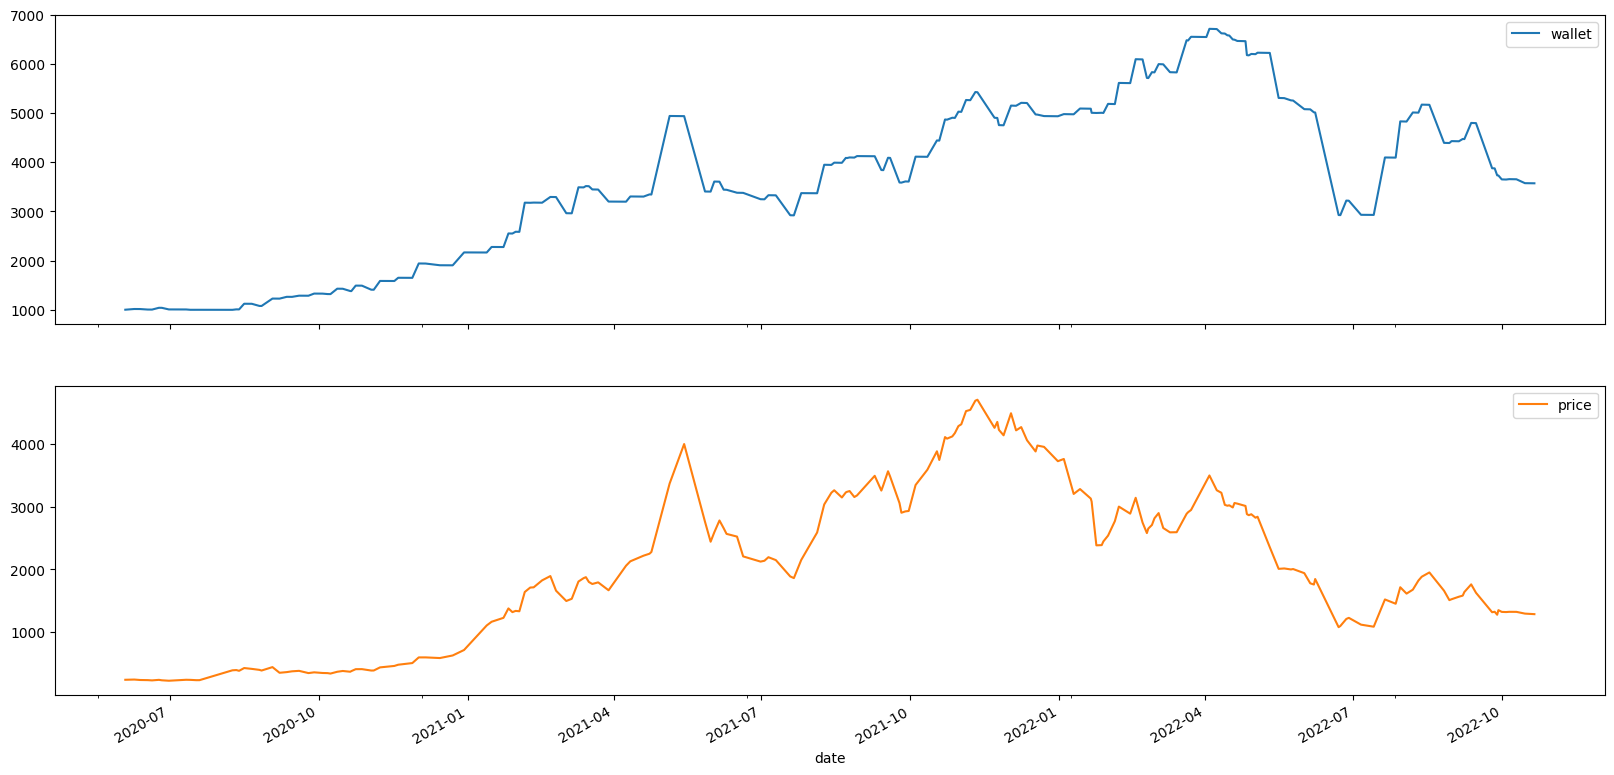

In [4]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.RSI_VWAP>19 and previous_row.RSI_VWAP<19 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.RSI_VWAP<80 and previous_row.RSI_VWAP>80 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

In [109]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'4h')
df['EMA200'] = ema_indicator(df.Close,70)
df['MACD'] = macd_diff(df.Close)
df['MACD_1'] = macd_signal(df.Close)
df.dropna(inplace=True)
print(df.shape)
df.head()

(5183, 9)


,Open,High,Low,Close,Volume,Timestamp,EMA200,MACD,MACD_1
Date,,,,,,,,,
2020-06-12 12:00:00,9495.60,9557.12,9360.81,9417.81,11978.929288,1591963200,9643.654654,-36.063019,-45.233301
2020-06-12 16:00:00,9417.98,9457.99,9301.00,9431.21,8467.594440,1591977600,9637.670297,-30.138632,-52.767959
2020-06-12 20:00:00,9431.11,9488.15,9409.85,9465.13,3766.920313,1591992000,9632.810007,-22.199654,-58.317872
2020-06-13 00:00:00,9464.96,9477.18,9398.49,9408.54,3836.910898,1592006400,9626.492542,-19.139682,-63.102793
2020-06-13 04:00:00,9408.54,9448.99,9362.08,9437.90,4722.275569,1592020800,9621.180076,-13.769434,-66.545152


Period : [2020-06-12 12:00:00] -> [2022-10-24 04:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1449.63 $
Performance vs US Dollar : 44.96 %
Buy and Hold Performence : 104.84 %
Performance vs Buy and Hold : -57.11 %
Best trade : +15.63 %, the 2021-01-14 20:00:00
Worst trade : -30.04 %, the 2021-05-26 20:00:00
Worst drawBack : -53.0 %
Total fees :  151.7 $

----- Trades Informations -----
Total trades on period : 63
Number of positive trades : 46
Number of negative trades :  17
Trades win rate ratio : 73.02 %
Average trades performance : 1.04 %
Average positive trades : 4.75 %
Median positive trades : 4.22 %
Average negative trades : -9.01 %
Median negative trades : -8.87 %

----- Plot -----


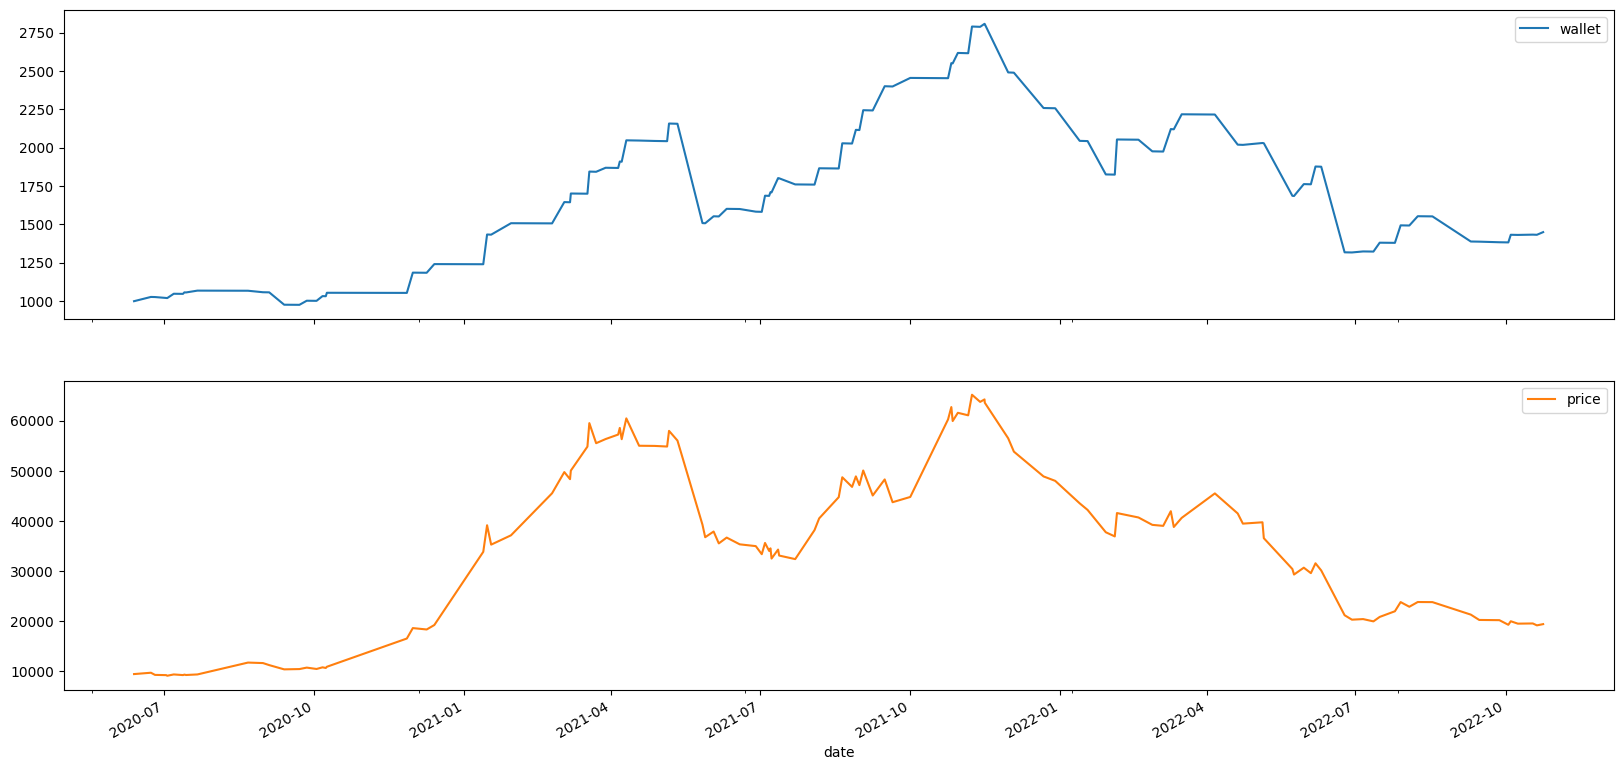

In [110]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1<0 and row.EMA200>row.Close else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1>0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

# SHORT

In [50]:
opened = False
    
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1<0 and row.EMA200>row.Close else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1>0 else False


result = pd.DataFrame()
trade_dict = {}
tp=0.003
sl=tp 
leverage = 10
last_buy_price = 0


for index, row in df.iterrows():
    if not opened:
        if buyCondition(row):
            trade_dict['buy_price'] = row.Close
            trade_dict['buy_date'] = index
            last_buy_price=row.Close
            opened = True
    else:
        if (1-tp)*trade_dict['buy_price']>=row.Low:
            trade_dict['sell_price'] = (1-tp)*trade_dict['buy_price']
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "TP"
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
        elif (1+sl)*trade_dict['buy_price']<=row.High:
            trade_dict['sell_price'] = (1+sl)*trade_dict['buy_price']
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "SL"
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
        elif sellCondition(row):
            trade_dict['sell_price'] = row.Close
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "SELL"
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
            
result 

,buy_price,buy_date,sell_price,sell_date,profit_pct,comment
0,37672.09,2022-05-03 23:20:00,37785.10627,2022-05-04 00:05:00,0.06,SL
1,37775.90,2022-05-04 00:10:00,37889.22770,2022-05-04 00:40:00,0.06,SL
2,38712.06,2022-05-04 13:55:00,38828.19618,2022-05-04 14:05:00,0.06,SL
3,38839.20,2022-05-04 14:10:00,38722.68240,2022-05-04 15:05:00,-0.06,TP
4,38762.10,2022-05-04 15:10:00,38878.38630,2022-05-04 15:40:00,0.06,SL
...,...,...,...,...,...,...
4707,19441.96,2022-10-24 02:40:00,19383.63412,2022-10-24 03:05:00,-0.06,TP
4708,19352.72,2022-10-24 03:10:00,19294.66184,2022-10-24 04:10:00,-0.06,TP
4709,19305.83,2022-10-24 04:15:00,19363.74749,2022-10-24 06:25:00,0.06,SL
4710,19357.71,2022-10-24 06:30:00,19299.63687,2022-10-24 06:55:00,-0.06,TP


In [52]:
result.profit_pct = -result.profit_pct

equity = 1000
for i in result.index:
    equity = (1+result.loc[i,'profit_pct'])*equity
    
equity

63.44712239681133

# Long

In [111]:
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
    
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1<0 and row.EMA200>row.Close else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1>0 else False

def process_iteration(take_profit, levier,df):
    opened = False
    result = pd.DataFrame()
    trade_dict = {}
    tp=take_profit/100
    sl=tp 
    leverage = levier
    last_buy_price = 0
    for index, row in df.iterrows():
        if not opened:
            if buyCondition(row):
                trade_dict['buy_price'] = row.Close
                trade_dict['buy_date'] = index
                last_buy_price=row.Close
                opened = True
        else:
            if (1-sl)*trade_dict['buy_price']>=row.Low:
                trade_dict['sell_price'] = (1-sl)*trade_dict['buy_price']
                trade_dict['sell_date'] = index
                trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
                trade_dict['comment'] = "SL"
                result = result.append(trade_dict,ignore_index=True)
                opened = False
                trade_dict = {}
            elif (1+tp)*trade_dict['buy_price']<=row.High:
                trade_dict['sell_price'] = (1+tp)*trade_dict['buy_price']
                trade_dict['sell_date'] = index
                trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
                trade_dict['comment'] = "TP"
                result = result.append(trade_dict,ignore_index=True)
                opened = False
                trade_dict = {}
            elif sellCondition(row):
                trade_dict['sell_price'] = row.Close
                trade_dict['sell_date'] = index
                trade_dict['profit_pct'] = leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
                trade_dict['comment'] = "SELL"
                result = result.append(trade_dict,ignore_index=True)
                opened = False
                trade_dict = {}
    result.profit_pct = -result.profit_pct
    equity = 1000
    for i in result.index:
        equity = (1+result.loc[i,'profit_pct'])*equity
    res = {'take_profit':take_profit/100, 'leverage':levier, 'equity':equity}      
    print(res)  
    return res

with ThreadPoolExecutor(max_workers=15) as executor:
    processes = [executor.submit(process_iteration,j, i,df) for i in range(1,12,1) for j in range(1,10)]
    
result = pd.DataFrame()    
for task in as_completed(processes):
    result = result.append(task.result(),ignore_index=True)
result.sort_values(by='equity',ascending=False)

{'take_profit': 0.09, 'leverage': 1, 'equity': 524.2711016273828}
{'take_profit': 0.07, 'leverage': 1, 'equity': 374.573185392336}
{'take_profit': 0.08, 'leverage': 1, 'equity': 724.7902781943885}
{'take_profit': 0.06, 'leverage': 1, 'equity': 1013.9568708923657}
{'take_profit': 0.06, 'leverage': 2, 'equity': 639.9005790451754}
{'take_profit': 0.05, 'leverage': 2, 'equity': 378.56216575296196}
{'take_profit': 0.05, 'leverage': 1, 'equity': 786.1189728391369}
{'take_profit': 0.04, 'leverage': 1, 'equity': 1131.2338496927462}
{'take_profit': 0.09, 'leverage': 2, 'equity': 148.55947864066533}
{'take_profit': 0.07, 'leverage': 2, 'equity': 79.75933973503032}
{'take_profit': 0.04, 'leverage': 2, 'equity': 837.9162097219573}
{'take_profit': 0.08, 'leverage': 2, 'equity': 286.60237856440216}
{'take_profit': 0.03, 'leverage': 2, 'equity': 325.92114162598523}
{'take_profit': 0.03, 'leverage': 1, 'equity': 678.174037422225}
{'take_profit': 0.08, 'leverage': 3, 'equity': 60.501121897865154}
{'tak

,take_profit,leverage,equity
17,0.01,11.0,1.408758e+07
25,0.01,10.0,9.085147e+06
46,0.01,9.0,5.374512e+06
20,0.01,8.0,2.917127e+06
29,0.01,7.0,1.452965e+06
...,...,...,...
97,0.07,10.0,4.483073e-17
89,0.09,10.0,7.433850e-22
64,0.07,11.0,1.055998e-22
63,0.08,11.0,3.778224e-24


In [118]:
take_profit = 10 #BTC 15m : 2, BTC 1h : 1.4, BTC 4h : 10
levier = 9 #BTC 15m : 9, BTC 1h : 6, BTC 4h : 7


def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1<0 and row.EMA200>row.Close else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.MACD_1>0 else False


opened = False
result = pd.DataFrame()
trade_dict = {}
tp=0.01#take_profit/1000
sl=tp 
leverage = levier
last_buy_price = 0
equity = 1000

for index, row in df.iloc[-4000:].iterrows():
    if not opened:
        if buyCondition(row):
            trade_dict['buy_price'] = row.Close
            trade_dict['buy_date'] = index
            last_buy_price=row.Close
            opened = True
    else:
        if (1-sl)*trade_dict['buy_price']>=row.Low:
            trade_dict['sell_price'] = (1-sl)*trade_dict['buy_price']
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = -leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "SL"
            equity = (1+trade_dict['profit_pct'])*equity
            trade_dict['equity'] = equity
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
        elif (1+tp)*trade_dict['buy_price']<=row.High:
            trade_dict['sell_price'] = (1+tp)*trade_dict['buy_price']
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = -leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "TP"
            equity = (1+trade_dict['profit_pct'])*equity
            trade_dict['equity'] = equity
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}
        elif sellCondition(row):
            trade_dict['sell_price'] = row.Close
            trade_dict['sell_date'] = index
            trade_dict['profit_pct'] = -leverage*((trade_dict['sell_price']-trade_dict['buy_price'])/trade_dict['buy_price'])
            trade_dict['comment'] = "SELL"
            equity = (1+trade_dict['profit_pct'])*equity
            trade_dict['equity'] = equity
            result = result.append(trade_dict,ignore_index=True)
            opened = False
            trade_dict = {}

result

,buy_price,buy_date,sell_price,sell_date,profit_pct,comment,equity
0,33829.40,2021-01-12 12:00:00,34167.6940,2021-01-12 16:00:00,-0.09,TP,9.100000e+02
1,34051.24,2021-01-12 20:00:00,33710.7276,2021-01-13 00:00:00,0.09,SL,9.919000e+02
2,34385.48,2021-01-13 08:00:00,34041.6252,2021-01-13 12:00:00,0.09,SL,1.081171e+03
3,35267.17,2021-01-17 08:00:00,34914.4983,2021-01-17 12:00:00,0.09,SL,1.178476e+03
4,35633.91,2021-01-17 16:00:00,35990.2491,2021-01-17 20:00:00,-0.09,TP,1.072414e+03
...,...,...,...,...,...,...,...
767,19123.43,2022-10-16 00:00:00,19314.6643,2022-10-16 16:00:00,-0.09,TP,4.175329e+06
768,19262.98,2022-10-16 20:00:00,19455.6098,2022-10-17 08:00:00,-0.09,TP,3.799549e+06
769,19145.94,2022-10-20 04:00:00,19337.3994,2022-10-20 12:00:00,-0.09,TP,3.457590e+06
770,19063.82,2022-10-20 16:00:00,18873.1818,2022-10-21 12:00:00,0.09,SL,3.768773e+06


In [119]:
result['time_diff'] = result.apply(lambda x: x.sell_date-x.buy_date, axis=1)
result['time_diff'].mean()

Timedelta('0 days 05:44:27.357512953')

In [120]:
result.buy_date.iloc[-1]-result.buy_date.iloc[0]

Timedelta('647 days 04:00:00')

<AxesSubplot: >

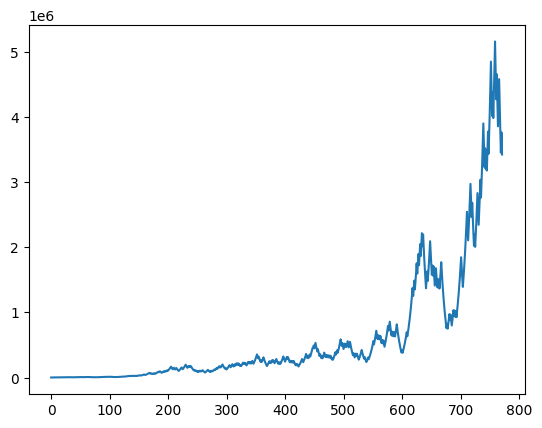

In [121]:
result.equity.plot()

In [92]:
result.comment.value_counts()

SL      10161
TP       5530
SELL       25
Name: comment, dtype: int64